In [1]:
!pip install numpy
!pip install matplotlib
!pip install scikit-image
!pip install pillow
!pip install opencv-python
!pip install timm
!pip install tqdm
# Check is at least python 3.9
import sys 
#assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/165.0 kB ? eta -:--:--
     -- ------------------------------------- 10.2/165.0 kB ? eta -:--:--
     ------------------ ------------------ 81.9/165.0 kB 919.0 kB/s eta 0:00:01
     -------------------------------------- 165.0/165.0 kB 1.2 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp39-cp39-win_amd64.whl.metadata (6.5 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.9 MB 8.6 MB/s eta 0:00:01
   ---- ----------------------------------- 0.8/7.9 MB 10.6 MB/s eta 0:00:01
   ----- ---------------------------------- 1.1/7.9 MB 10.4 MB/s eta 0:00:01
   ------ --------------------------------- 1.3/7.9 MB 7.4 MB

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
from typing import Callable
import os
from datetime import datetime
from enum import Enum
import random
from skimage.color import rgb2gray, rgb2hsv
from skimage import filters
from skimage import segmentation
from skimage.morphology import remove_small_holes, remove_small_objects
import cv2 as cv


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import timm
import torchvision
# from torchvision.models.vision_transformer import vit_b_16
# from torchvision.models import ViT_B_16_Weights

c:\Users\1\Anaconda\envs\iapr-v1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import platform

# Get os name
os_name = platform.system().lower()
num_workers = 8

# OS X
if 'darwin' in os_name:
    print("Detected OS X")
    %pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.1
# Linux 
elif 'linux' in os_name:
    print("Detected Linux")
    %pip install torch==1.8.1 torchvision==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
# Windows 
else:
    print("Detected Windows")
    num_workers = 0  # Hard fix for Windows users
    %pip install torch==1.12.0 torchvision==0.13 -f https://download.pytorch.org/whl/torch_stable.html


Detected Windows
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu116/torch-1.12.0%2Bcu116-cp39-cp39-win_amd64.whl (2388.0 MB)
  Using cached https://download.pytorch.org/whl/cu116/torchvision-0.13.0%2Bcu116-cp39-cp39-win_amd64.whl (2.6 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0
    Uninstalling torch-2.3.0:
      Successfully uninstalled torch-2.3.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.0
    Uninstalling torchvision-0.18.0:
      Successfully uninstalled torchvision-0.18.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import random
import torch

# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
class ImageType(Enum):
    NEUTRAL = "1. neutral_bg"
    NOISY = "2. noisy_bg"
    HAND = "3. hand"
    NEUTRAL_OOD = "4. neutral_bg_outliers"
    NOISY_OOD = "5. noisy_bg_outliers"
    HAND_OOD = "6. hand_outliers"
    
def loadImageOfType(type: ImageType, downsample: int = 1, grayscale: bool = False):
    # directory = f"./data/train/{type}"
    directory = os.path.join(".", "data", "train", type.value)
    images = os.listdir(directory)
    img = np.array(Image.open(os.path.join(directory, random.choice(images)))) 
    if downsample > 1:
        img = img[::downsample, ::downsample, :]
    if grayscale:
        img = (rgb2gray(img)*255).astype(np.uint8)
        
    # img = filters.sobel(img)
    
    return img
        


## Preprocessing

In [5]:
def filter_circles(circle_array):
    """
    Filter the input array of circles to return only the largest circle at each unique center coordinate.
    
    Parameters:
    - circle_array (numpy.ndarray): A 2D array where each row represents a circle with the format [x_center, y_center, radius].
    
    Returns:
    - numpy.ndarray: A 2D array containing only the largest circles at each unique center coordinate, with the same format as the input array.
    
    Description:
    The function first identifies all unique center coordinates from the input array. 
    For each unique center, it then finds the circle with the largest radius among all circles with that center.
    The result is a new array consisting of these largest circles, preserving the order of the first occurrence of each center in the input array.
    """

    
    # Find unique center coordinates
    unique_centers, unique_indices = np.unique(circle_array[:, :2], axis=0, return_index=True)
    
    # Get the indices of circles with largest radius for each unique center
    largest_circles = []
    for center in unique_centers:
      largest_circle = np.array((center[0], center[1], 0))
      for j in range(len(circle_array)):
        circle = circle_array[j]
        if (circle[0] == center[0] and circle[1]==center[1] and circle[2] > largest_circle[2]):
          largest_circle[2] = circle[2] 
      largest_circles.append(largest_circle)
    
    return np.array(largest_circles)

In [6]:
# the input is a cv image so x and y are swapped
def extract_circles_images(x, y, r, img, down):
    """
    Extracts and returns a sub-image centered around a specified circle with modified color channels.

    Parameters:
    - x (int): The x-coordinate of the circle's center.
    - y (int): The y-coordinate of the circle's center.
    - r (int): The radius of the circle.
    - img (numpy.ndarray): The input image from which to extract the circle, assumed to be in BGR format.
    - down (float): A scaling factor to adjust the size of the extracted area based on the circle's dimensions.

    Returns:
    - numpy.ndarray: The extracted sub-image 
    """
    factor = r+10 #TODO here , might have a huge impact
    left = (x - factor)*down
    right = (x + factor)*down
    up = (y - factor)*down
    bottom = (y + factor)*down
    output = img.copy()
    output[:, :, 0] = img[:, :, 2]
    output[:, :, 2] = img[:, :, 0]
    return output[up:bottom, left:right, :]

In [7]:
def find_circles(path, debug=False):
    """
    Detects circles in an image, draws them on a copy of the image, and extracts these circles as separate images.
    

    Parameters:
    - path (str): The file path to the image in which circles are to be detected.
    - debug (bool, optional): If set to True, the function will display each circle's extracted image and the final
      annotated image. 

    Returns:
    - list of numpy.ndarray: A list containing the extracted images of detected circles.
    """

    img = cv.imread(path)
    full_size_img = img.copy()
    down = 3  # downscale factor for processing

    # Resize the image
    size = (int(img.shape[1] / down), int(img.shape[0] / down))
    img = cv.resize(img, size, interpolation=cv.INTER_LINEAR)

    # Create a copy and swap color channels for visualization
    output = img.copy()
    output[:, :, 0] = img[:, :, 2]
    output[:, :, 2] = img[:, :, 0]

    img[:, :, 2] = 0

    # Prepare image for circle detection
    gray = cv.blur(cv.cvtColor(img, cv.COLOR_BGR2GRAY), (8, 8))

    # Detect circles
    circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT_ALT, dp=1, minDist=50,
                              minRadius=50, maxRadius=200, param1=5, param2=0.6)

    circles_imgs = []
    if circles is not None:
        # Filter and round circle parameters
        circles = np.round(circles[0, :]).astype("int")
        circles = filter_circles(circles)
        print(f"Detected {len(circles)} circles")

        for (x, y, r) in circles:
            # Draw circles and rectangles on the output
            cv.circle(output, (x, y), r, (0, 255, 0), 4)
            cv.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 255, 0), -1)
            # Extract and append each circle's image from the full-size image
            new_circle = extract_circles_images(x, y, r, full_size_img, down)
            circles_imgs.append(new_circle)
            if debug:
                # Display each circle's image if debugging
                plt.imshow(new_circle)
                plt.show()

    if debug:
        # Display the final output image with all circles drawn if debugging
        plt.imshow(output)
        plt.show()

    return circles_imgs

In [8]:
def get_training_data_paths():
    """
    Returns the list of files for training.

    Returns:
    - list of str: A list containing the full paths to all files located within the subdirectories of the
      training data base directory.
    """
    training_paths = []  
    base_dir = "./data/iapr24-coin-counter/train/"  

    for d in os.listdir(base_dir):
        training_dir = f"{base_dir}/{d}"  
        for path in os.listdir(training_dir):
            file_path = f"{training_dir}/{path}" 
            training_paths.append(file_path)  

    return training_paths 

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [10]:
resnet152 = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V2).to(device)
feature_extractor = torch.nn.Sequential(*list(resnet152.children())[:-1])

def extract_features(input_image):
    """
    Extracts feature vectors from an input image using the ResNet-152 model pretrained on the ImageNet dataset.


    Parameters:
    - input_image (numpy.ndarray): The input image array.

    Returns:
    - torch.Tensor: A 1D tensor containing the extracted features from the image.
    """

    # Set the feature extractor model to evaluation mode
    feature_extractor.eval()

    input_image = Image.fromarray(input_image)
    preprocess = transforms.Compose([
        transforms.CenterCrop(850),  # Center crop to 850x850
        transforms.ToTensor(),       # Convert the image to a PyTorch tensor
    ])
    input_tensor = preprocess(input_image)  

    input_batch = input_tensor.unsqueeze(0)

    input_batch = input_batch.to(device)
    feature_extractor.to(device)

    with torch.no_grad():
        features = feature_extractor(input_batch)

    features = torch.flatten(features)

    return features

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to C:\Users\1/.cache\torch\hub\checkpoints\resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:07<00:00, 31.6MB/s] 


In [11]:

def freeze_first_layers(feature_extractor):
    """
    Freezes the first 6 layers of the feature extrator 
    """
    for name, param in feature_extractor.named_parameters():
        if not name.startswith("7."):
            param.requires_grad = False
    return feature_extractor




feature_extractor = freeze_first_layers(feature_extractor)

for name, param in feature_extractor.named_parameters():
    if param.requires_grad:
        print(name)

7.0.conv1.weight
7.0.bn1.weight
7.0.bn1.bias
7.0.conv2.weight
7.0.bn2.weight
7.0.bn2.bias
7.0.conv3.weight
7.0.bn3.weight
7.0.bn3.bias
7.0.downsample.0.weight
7.0.downsample.1.weight
7.0.downsample.1.bias
7.1.conv1.weight
7.1.bn1.weight
7.1.bn1.bias
7.1.conv2.weight
7.1.bn2.weight
7.1.bn2.bias
7.1.conv3.weight
7.1.bn3.weight
7.1.bn3.bias
7.2.conv1.weight
7.2.bn1.weight
7.2.bn1.bias
7.2.conv2.weight
7.2.bn2.weight
7.2.bn2.bias
7.2.conv3.weight
7.2.bn3.weight
7.2.bn3.bias


In [12]:
def get_test_data_paths():
    """
    Returns the list of files for Testing.

    Returns:
    - list of str: A list containing the full paths to all files located within the subdirectories of the
      testing data base directory.
    """
    test_paths = []
    base_dir = "./data/iapr24-coin-counter/test/"
    for path in os.listdir(base_dir):
        file_path = f"{base_dir}/{path}"
        test_paths.append(file_path)
    return test_paths



## Training on individual coin

In [13]:
class_names = ["chf_5", "chf_2", "chf_1", "chf_0.5", "chf_0.2", "chf_0.1", "chf_0.05", "eur_2", "eur_1", "eur_0.5", "eur_0.2", "eur_0.1", "eur_0.05", "eur_0.02", "eur_0.01", "OOD", "bg"]


In [14]:
def get_training_set_size():
    """
    Calculates and returns the total number training Files

    Returns:
    - int: The total number of files across all specified class directories, representing the size of the training set.
    """

    size = 0  
    labeled_coins_dir = "./data/labeled_coins/"  

    for index, c in enumerate(class_names):
        selected_dir = f"{labeled_coins_dir}{c}" 
        files = os.listdir(selected_dir)  
        size += len(files)  

    return size  

print(get_training_set_size())

578


### background classifier

In [81]:
data_set_size = get_training_set_size()



def prepare_training_data_bg():
    """
    Prepares  training datasets for a background Classifier

    Outputs:
    - X_bg (torch.Tensor): A tensor filled with extracted features of each image.
    - Y_bg (torch.Tensor): A tensor filled with labels for each image where '1' denote 'bg' and '0' denotes other classes.

    """

    X_bg = torch.zeros((data_set_size, 2048)).to(device)
    Y_bg = torch.zeros(data_set_size).to(device)
    data_index = 0

    for index, c in enumerate(class_names):
        print(f"extracting class {index}")
        labeled_coins_dir = "./data/labeled_coins/"
        selected_dir = f"{labeled_coins_dir}{c}"
        files = os.listdir(selected_dir)
        for j, file in enumerate(files):
            selected_file_path = f"{selected_dir}/{file}"
            coin = Image.open(selected_file_path)
            x = extract_features(np.array(coin))
            X_bg[data_index] = x
            val_y = 0
            if (index == class_names.index("bg")):
                val_y = 1
            Y_bg[data_index] = val_y

            
            data_index += 1
    return X_bg,Y_bg


X_bg,Y_bg = prepare_training_data_bg()

extracting class 0
extracting class 1
extracting class 2
extracting class 3
extracting class 4
extracting class 5
extracting class 6
extracting class 7
extracting class 8
extracting class 9
extracting class 10
extracting class 11
extracting class 12
extracting class 13
extracting class 14
extracting class 15
extracting class 16


In [82]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
def train_test_classifier(classifier,criterion,optimizer,X,Y,nb_epochs,name,flatten_input = True,to_long =False):
    """
    Trains a classifier on the given data and evaluates it using the specified criterion and optimizer.

    Parameters:
    classifier (torch.nn.Module): The neural network model to be trained.
    criterion (torch.nn.Module): The loss function to be used for training.
    optimizer (torch.optim.Optimizer): The optimizer used for updating the model parameters.
    X (torch.Tensor): The input features for the dataset.
    Y (torch.Tensor): The target labels for the dataset.
    nb_epochs (int): The number of epochs for training the model.
    name (str): The name identifier for the model, used for saving the best model and plotting.
    to_long (Bool) : Set if the Y_prediction have to be cast to Long.
    """
    
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)
    if flatten_input:
        trainY = trainY.unsqueeze(0).view(-1, 1)
        testY = testY.unsqueeze(0).view(-1, 1)
    train_losses= []
    test_losses = []
    best_test_loss = float('inf')
    best_model_path = f'best_model_{name}.pth'

    for epoch in tqdm(range(nb_epochs)):
        optimizer.zero_grad()
                
        pred = classifier(trainX)
        if to_long:
            train_loss = criterion(pred, trainY.to(device).long()) 
        else :
            train_loss = criterion(pred, trainY.to(device)) 

        train_loss.backward() 
        optimizer.step() 

        with torch.no_grad():
            test_pred = classifier(testX)
            if to_long:
                test_loss = criterion(test_pred, testY.to(device).long()) 
            else :
                test_loss = criterion(test_pred, testY.to(device)) 
            # Save losses for plotting
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

        if test_loss.item() < best_test_loss:
            best_test_loss = test_loss.item()
            torch.save(classifier.state_dict(), best_model_path)

    # Load the best model
    # Create a new classifier instance and load the best model
    best_classifier = copy.deepcopy(classifier)
    best_classifier.load_state_dict(torch.load(best_model_path))

    # Plotting the training and test losses
    plt.figure(figsize=(10, 5))
    plt.plot(test_losses, label=f'Test Loss {name}')
    plt.plot(train_losses, label=f'Train Loss {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale("log")
    plt.title(f"Train and Test loss for the {name}")
    plt.legend()
    plt.show()

    return best_classifier

In [83]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
def train_classifier(classifier,criterion,optimizer,X,Y,nb_epochs,name,flatten_input = True,to_long =False):
    """
    Trains a classifier on the full data.

    Parameters:
    classifier (torch.nn.Module): The neural network model to be trained.
    criterion (torch.nn.Module): The loss function to be used for training.
    optimizer (torch.optim.Optimizer): The optimizer used for updating the model parameters.
    X (torch.Tensor): The input features for the dataset.
    Y (torch.Tensor): The target labels for the dataset.
    nb_epochs (int): The number of epochs for training the model.
    name (str): The name identifier for the model, used for saving the best model and plotting.
    to_long (Bool) : Set if the Y_prediction have to be cast to Long.
    """
    
    if flatten_input:
        Y = Y.unsqueeze(0).view(-1, 1)

    train_losses= []


    for epoch in tqdm(range(nb_epochs)):
        optimizer.zero_grad()
                
        pred = classifier(X)
        if to_long:
            train_loss = criterion(pred, Y.to(device).long()) 
        else :
            train_loss = criterion(pred, Y.to(device)) 

        train_loss.backward() 
        optimizer.step() 


        train_losses.append(train_loss.item())

    # Plotting the training and test losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label=f'Train Loss {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale("log")
    plt.title(f"Train loss for the {name}")
    plt.legend()
    plt.show()


  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [00:35<00:00, 33.77it/s]


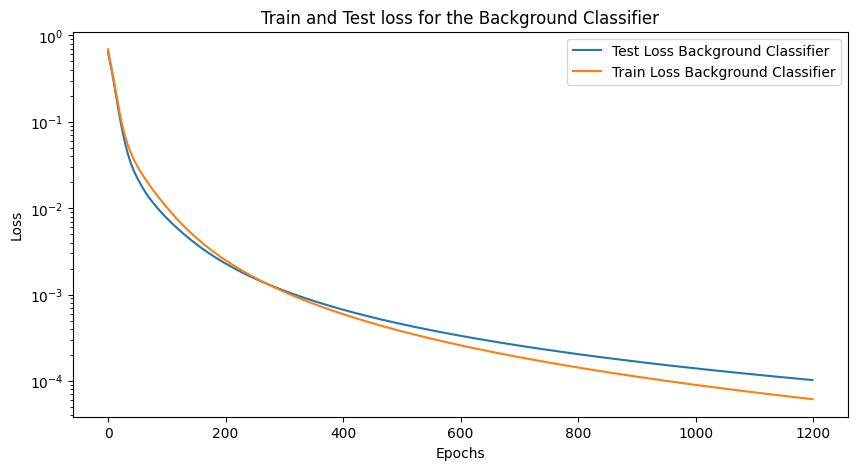

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=1, bias=True)
  (3): Sigmoid()
)

In [84]:
# Define the binary classification model with a sequential neural network
bg_classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 1), 
    torch.nn.Sigmoid()
)
bg_classifier = bg_classifier.to(device)
criterion_bg = torch.nn.BCELoss()
optimizer_bg = torch.optim.Adam(bg_classifier.parameters(), lr=5e-4)



train_test_classifier(bg_classifier,criterion_bg,optimizer_bg,X_bg,Y_bg,1200,"Background Classifier") 


  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:16<00:00, 177.17it/s]


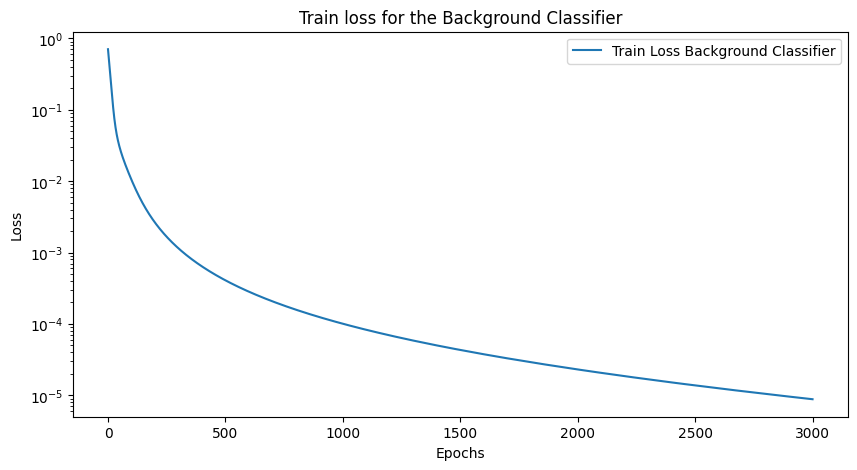

In [85]:
# Retrain the Bg classifier on the full data (splitting the data for test )
bg_classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 1), 
    torch.nn.Sigmoid()
)
bg_classifier = bg_classifier.to(device)
criterion_bg = torch.nn.BCELoss()
optimizer_bg = torch.optim.Adam(bg_classifier.parameters(), lr=5e-4)



train_classifier(bg_classifier,criterion_bg,optimizer_bg,X_bg,Y_bg,3000,"Background Classifier") 

### training ood classifier

In [86]:
labeled_coins_dir = "./data/labeled_coins/"
data_set_size = get_training_set_size() - len(os.listdir(labeled_coins_dir+"bg"))

def prepare_training_data_ood():
    """
    Prepares  training datasets for a Out of Distribution Classifier

    Outputs:
    - X_ood (torch.Tensor): A tensor filled with extracted features of each image.
    - Y_ood (torch.Tensor): A tensor filled with labels for each image where '1' denote 'out of distriubtion' and '0' denotes others.

    """

    X_ood = torch.zeros((data_set_size, 2048)).to(device)
    Y_ood = torch.zeros(data_set_size).to(device)

    data_index = 0

    for index, c in enumerate(class_names):
        if index == len(class_names) - 1: continue
        print(f"extracting class {index}")
        labeled_coins_dir = "./data/labeled_coins/"
        selected_dir = f"{labeled_coins_dir}{c}"
        files = os.listdir(selected_dir)
        for j, file in enumerate(files):
            selected_file_path = f"{selected_dir}/{file}"
            coin = Image.open(selected_file_path)
            x = extract_features(np.array(coin))
            X_ood[data_index] = x
            val_y = 0
            if (index == class_names.index("OOD")):
                val_y = 1
            Y_ood[data_index] = val_y

            
            data_index += 1
    return X_ood,Y_ood


 
X_ood,Y_ood = prepare_training_data_ood()

extracting class 0
extracting class 1
extracting class 2
extracting class 3
extracting class 4
extracting class 5
extracting class 6
extracting class 7
extracting class 8
extracting class 9
extracting class 10
extracting class 11
extracting class 12
extracting class 13
extracting class 14
extracting class 15


100%|██████████| 2000/2000 [00:32<00:00, 61.84it/s] 


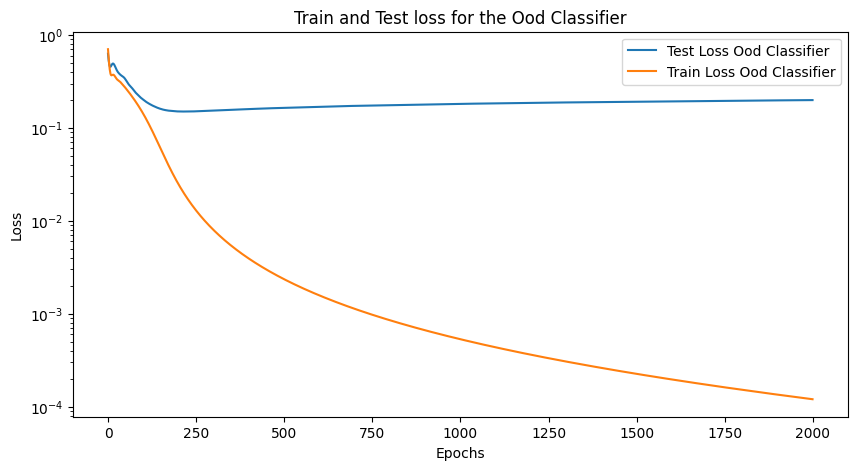

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=1, bias=True)
  (3): Sigmoid()
)

In [87]:
ood_classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 1), 
    torch.nn.Sigmoid()
)

ood_classifier = ood_classifier.to(device)


criterion_ood = torch.nn.BCELoss()
selected_param = list(filter(lambda p: p.requires_grad, feature_extractor.parameters()))


optimizer_ood = torch.optim.Adam(list(ood_classifier.parameters()) + selected_param, lr=5e-4)


train_test_classifier(ood_classifier,criterion_ood,optimizer_ood,X_ood,Y_ood,2000,"Ood Classifier")

            

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:26<00:00, 115.01it/s]


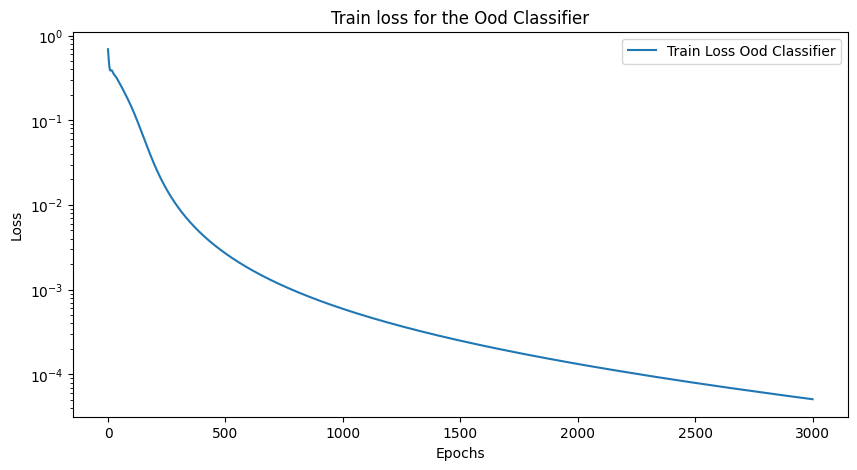

In [88]:
#Full data training
ood_classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 1), 
    torch.nn.Sigmoid()
)

ood_classifier = ood_classifier.to(device)


criterion_ood = torch.nn.BCELoss()
selected_param = list(filter(lambda p: p.requires_grad, feature_extractor.parameters()))


optimizer_ood = torch.optim.Adam(list(ood_classifier.parameters()) + selected_param, lr=5e-4)


train_classifier(ood_classifier,criterion_ood,optimizer_ood,X_ood,Y_ood,3000,"Ood Classifier")

### training chf/eur classifier

In [65]:
labeled_coins_dir = "./data/labeled_coins/"
data_set_size = get_training_set_size() - len(os.listdir(labeled_coins_dir+"bg")) - len(os.listdir(labeled_coins_dir+"OOD"))

def prepare_training_data_chf_eur(return_test_images=False):
    # for more detailed investigation assign half of the training subset for validation 
    X_chf_eur_train = []
    X_chf_eur_test = []
    Y_chf_eur_train = []
    Y_chf_eur_test = []
    imgs_test = []

    for index, c in enumerate(class_names):
        if index >= len(class_names) - 2: continue

        print(f"extracting class {index}")
        selected_dir = f"{labeled_coins_dir}{c}"
        files = os.listdir(selected_dir)
        n_train = len(files) / 2
        for j, file in enumerate(files):
            target = torch.tensor([index]).to(device)

            selected_file_path = f"{selected_dir}/{file}"
            coin = Image.open(selected_file_path)
            x = extract_features(np.array(coin))
            if j <= n_train:
                X_chf_eur_train.append(x)
                Y_chf_eur_train.append(index)
            else:
                X_chf_eur_test.append(x)
                Y_chf_eur_test.append(index)
                imgs_test.append(coin)
                
    X_chf_eur_train = torch.stack(X_chf_eur_train).to(device)
    X_chf_eur_test = torch.stack(X_chf_eur_test).to(device)
    Y_chf_eur_train = torch.tensor(Y_chf_eur_train).to(device)
    Y_chf_eur_test = torch.tensor(Y_chf_eur_test).to(device)

    if return_test_images:
        return X_chf_eur_train, X_chf_eur_test, Y_chf_eur_train, Y_chf_eur_test, imgs_test
    return X_chf_eur_train, X_chf_eur_test, Y_chf_eur_train, Y_chf_eur_test

X_chf_eur_train, X_chf_eur_test, Y_chf_eur_train, Y_chf_eur_test, imgs_test = prepare_training_data_chf_eur(return_test_images=True)

extracting class 0
extracting class 1
extracting class 2
extracting class 3
extracting class 4
extracting class 5
extracting class 6
extracting class 7
extracting class 8
extracting class 9
extracting class 10
extracting class 11
extracting class 12
extracting class 13
extracting class 14


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:01<00:00, 307.76it/s]


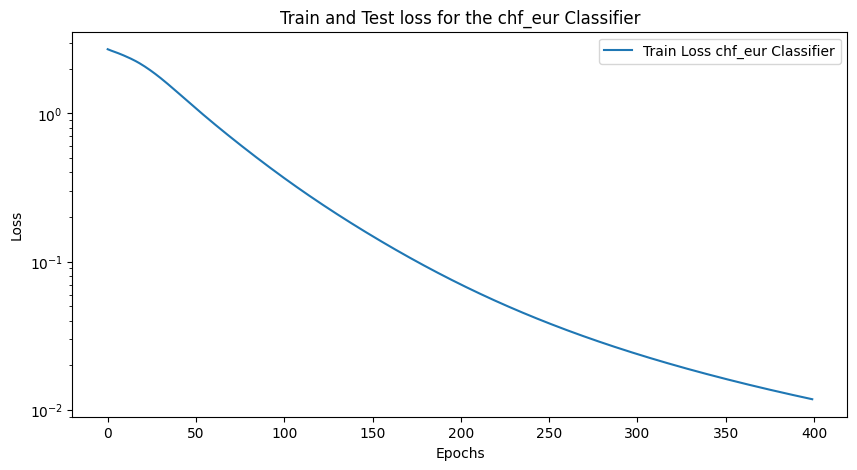

In [75]:
linear = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 15), 
)

linear = linear.to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(linear.parameters())+selected_param, lr=5e-4)

train_classifier(linear,criterion,optimizer,X_chf_eur_train,Y_chf_eur_train,400,"chf_eur Classifier",flatten_input=False,to_long = True)

In [79]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

labels = ["5CHF","2CHF","1CHF","0.5CHF","0.2CHF","0.1CHF","0.05CHF","2EUR","1EUR","0.5EUR","0.2EUR","0.1EUR","0.05EUR","0.02EUR","0.01EUR"]
def test_classifier(classifier,X_test,Y_test,name,plot_conf_matrix=True):
    """
    Computes accuracy and (optionally) confusion matrix for a trained model 

    Parameters:
    classifier (torch.nn.Module): The trained neural network.
    X_test (torch.Tensor): The input features for the test dataset.
    Y_test (torch.Tensor): The target labels for the test dataset.
    name (str): The name identifier for the model, used for plotting.
    plot_conf_matrix(bool): whether to display the confusion matrix or not

    """
    Y_test = Y_test.detach().cpu().numpy()
    with torch.no_grad():
        classifier.eval()
        pred = classifier(X_test).detach().cpu().numpy()
    
    Y_pred = np.argmax(pred, axis=1)
    print(f"Accuracy score for {name}: {accuracy_score(Y_test, Y_pred)}")
    
    if plot_conf_matrix:
        conf_matrix = confusion_matrix(Y_test, Y_pred)
        plt.figure(figsize=(10, 5))
        sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f"Confusion matrix for {name}")
        plt.show()

Accuracy score for chf_eur Classifier: 0.823170731707317


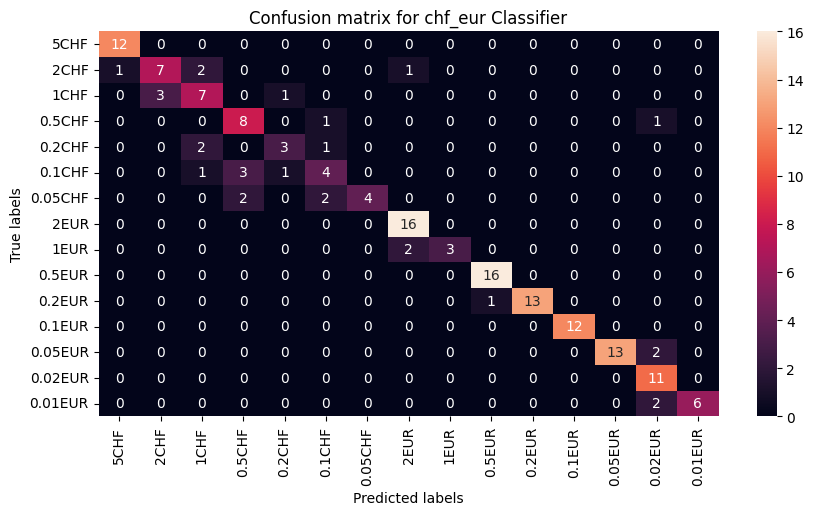

In [57]:
test_classifier(linear, X_chf_eur_test, Y_chf_eur_test, "chf_eur Classifier", plot_conf_matrix=True)

Based on the validation accuracy and confusion matrix, we observe that 1. overall, accuracy of predictions is high 2. there are still groups of classes that are hard for the model to distinguish between:
- 0.5 chf - 0.2 chf - 0.1 chf
- 1 chf - 2 chf
- 0.05 euro - 0.02 euro - 0.01 euro 
- 1 euro - 2 euro 

By calculating the coin’s radius, we can use this additional feature to more accurately differentiate between similar-looking coins.

In [89]:
labeled_coins_dir = "./data/labeled_coins/"
data_set_size = get_training_set_size() - len(os.listdir(labeled_coins_dir+"bg")) - len(os.listdir(labeled_coins_dir+"OOD"))


def prepare_training_data_chf_eur():

    X_chf_eur = torch.zeros((data_set_size, 2048)).to(device)
    Y_chf_eur = torch.zeros(data_set_size).to(device)

    data_index = 0


    for index, c in enumerate(class_names):
        if index >= len(class_names) - 2: continue

        print(f"extracting class {index}")
        selected_dir = f"{labeled_coins_dir}{c}"
        files = os.listdir(selected_dir)
        for j, file in enumerate(files):
            target = torch.tensor([index]).to(device)

            selected_file_path = f"{selected_dir}/{file}"
            coin = Image.open(selected_file_path)
            x = extract_features(np.array(coin))
            X_chf_eur[data_index] = x
            Y_chf_eur[data_index] = index

            
            data_index += 1
    return X_chf_eur,Y_chf_eur
X_chf_eur,Y_chf_eur = prepare_training_data_chf_eur()

extracting class 0
extracting class 1
extracting class 2
extracting class 3
extracting class 4
extracting class 5
extracting class 6
extracting class 7
extracting class 8
extracting class 9
extracting class 10
extracting class 11
extracting class 12
extracting class 13
extracting class 14


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:06<00:00, 43.22it/s]


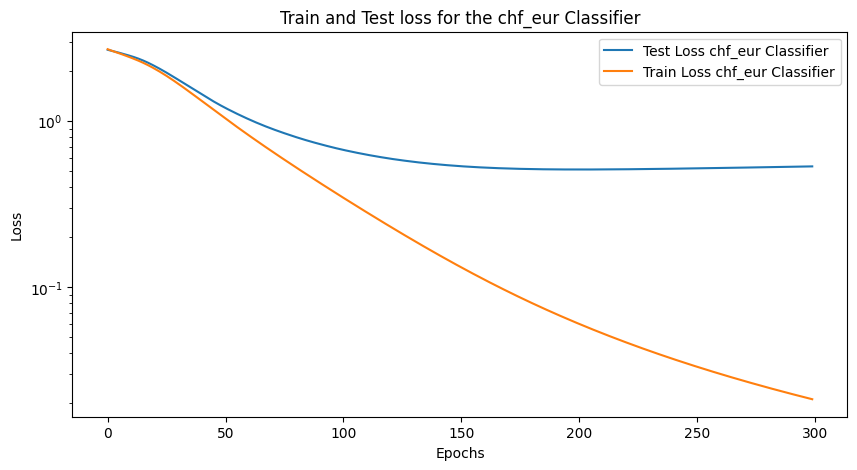

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=15, bias=True)
)

In [90]:
linear = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 15), 
)

linear = linear.to(device)


criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(list(linear.parameters())+selected_param, lr=5e-4)

train_test_classifier(linear,criterion,optimizer,X_chf_eur,Y_chf_eur,300,"chf_eur Classifier",flatten_input=False,to_long = True)


100%|██████████| 400/400 [00:03<00:00, 102.31it/s]


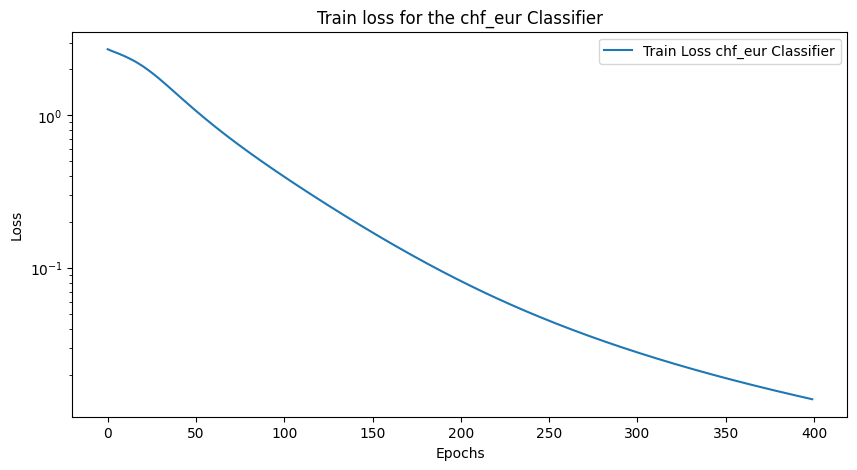

In [91]:
#Full data Training

linear = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 15), 
)

linear = linear.to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(linear.parameters())+selected_param, lr=5e-4)

train_classifier(linear,criterion,optimizer,X_chf_eur,Y_chf_eur,400,"chf_eur Classifier",flatten_input=False,to_long = True)

In [92]:
csv_header = "id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD"



In [93]:
def path_to_filename(path):
    return path.split("/")[-1].split(".")[0]

## Testing

### filter functions

In [58]:

def find_radius(coin, min_radius, max_radius,down=2 ,debug=False):
    """
    Finds the radius of the the coin in the image.

    Args:
        coin (ndarray): The input image containing the coin.
        min_radius (float): The minimum expected radius of the coin.
        max_radius (float): The maximum expected radius of the coin.
        debug (bool, optional): If True, displays debug information and visualization. Default is False.

    Returns:
        int: The radius of the detected coin. Returns 0 if no circle is found.
    """
    img = (rgb2gray(coin)*255).astype(np.uint8)
    img = cv.blur(img, (16, 16))[::down, ::down]
    
    min_r = int((min_radius*0.9)//down)
    max_r = int((max_radius*1.5)//down)
    
    circle = cv.HoughCircles(img, cv.HOUGH_GRADIENT_ALT, dp=1, minDist = 50, minRadius=min_r, maxRadius=max_r, param1=50, param2=0.8)
    
    if circle is not None:
        circles = np.round(circle[0, :]).astype("int")
        circles = filter_circles(circles)
    
        for (x, y, r) in circles:
            # print(x, y, r)
            # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
            radius = down*r
            if False: #TODO ANTOINE
                cv.circle(coin, (down*x, down*y), down*r, (0, 255, 0), 4)
                plt.title(f"radius: {radius}")
                plt.imshow(coin)
                plt.show()
            return radius
    else:
        if debug:
            print("no circle found")
        return 0
               

In [59]:
def find_radius_eur_cents(coin, min_radius, max_radius, debug=False):
    return find_radius(coin,min_radius,max_radius,down=3,debug=debug)

In [60]:
def test_chf_cents(coin, pred_class, debug=False):
    """
    Determines the class of a Swiss coin based on its radius.
    This functions is speciliazed for 50,20 and 10 cents.

    Parameters:
    coin (array-like): The coin image.
    pred_class (int): The initial predicted class of the coin.
    debug (bool, optional): If True, prints debug information. Default is False.

    Returns:
    int: The predicted class of the coin. Possible values are:
         - 3 for 50 cents
         - 4 for 20 cents
         - 5 for 10 cents

    Notes:
    - The function calculates the coin's radius using the `find_radius` function.
    - If the calculated radius is less than 150, the function returns the initial predicted class.
    - The function then determines the closest matching class based on predefined radii for 50, 20, and 10 cent coins.
    """
    previous_class = pred_class
    cents_20_radius = 240
    cents_10_radius = 228
    cents_50_radius = 208
    
    radius = find_radius(coin, min_radius=cents_50_radius, max_radius=cents_10_radius, debug=debug)
    if radius < 150: return pred_class
        
    values = np.array((cents_50_radius, cents_20_radius, cents_10_radius))
    classes = [3, 4, 5]
    pred = classes[np.argmin(np.abs(values - radius))]
    if debug:
        print(f"returning {class_names[pred]}, before {class_names[previous_class]}")
    return pred

In [61]:
def test_chf_francs(coin, pred_class, debug=False):
    """
    Determines the class of a Swiss coin based on its radius.
    This functions is speciliazed for 1 and 2 swiss franc.

    Parameters:
    coin (array-like): The coin image.
    pred_class (int): The initial predicted class of the coin.
    debug (bool, optional): If True, prints debug information. Default is False.

    Returns:
    int: The predicted class of the coin. Possible values are:
         - 1 for 2 francs
         - 2 for 1 franc

    Notes:

    - The function calculates the coin's radius using the `find_radius`.
    - If the calculated radius is less than 240, the function returns the initial predicted class.
    - The function then determines the closest matching class based on predefined radii for 2 franc and 1 franc coins.
    """
    francs_2_radius = 315
    francs_1_radius = 265
    
    radius = find_radius(coin, min_radius=francs_1_radius, max_radius=francs_2_radius, debug=debug)
    if radius < 240: return pred_class
        
    values = np.array((francs_2_radius, francs_1_radius))
    classes = [1, 2]
    pred = classes[np.argmin(np.abs(values - radius))]
    if debug:
        print(f"returning {class_names[pred]} - before {class_names[pred_class]}")
    return pred

In [62]:
def test_eur_cents(coin, pred_class, debug=False):
    """
    Determines the class of a Euro cent coin based on its radius.

    Parameters:
    coin (array-like): The coin image.
    pred_class (int): The initial predicted class of the coin.
    debug (bool, optional): If True, prints debug information. Default is False.

    Returns:
    int: The predicted class of the coin. Possible values are:
         - 12 for 5 cents
         - 13 for 2 cents
         - 14 for 1 cent

    Notes:
    - The function calculates the coin's radius using the `find_radius_eur_cents`.
    - If the calculated radius is less than 170, the function returns the initial predicted class.
    - The function then determines the closest matching class based on predefined radii for 5, 2, and 1 cent coins.
    """
    cents_1_radius = 192
    cents_2_radius = 222
    cents_5_radius = 249
    
    radius = find_radius_eur_cents(coin, min_radius=cents_1_radius, max_radius=cents_5_radius, debug=debug)
    if radius < 170: return pred_class
        
    values = np.array((cents_5_radius, cents_2_radius, cents_1_radius))
    classes = [12, 13, 14]
    pred = classes[np.argmin(np.abs(values - radius))]
    if debug:
        print(f"returning {class_names[pred]} - before {class_names[pred_class]}")
    return pred

    

In [63]:
def test_eur_1_2(coin, pred_class, debug=False):
    """
    Determines the class of a Euro 1 or 2 coin based on its radius.

    Parameters:
    coin (array-like): The coin image.
    pred_class (int): The initial predicted class of the coin.
    debug (bool, optional): If True, prints debug information. Default is False.

    Returns:
    int: The predicted class of the coin. Possible values are:
         - 7 for 2 euros
         - 8 for 1 euro

    Notes:
    - The function calculates the coin's radius using the `find_radius` function.
    - If the calculated radius is less than 240, the function returns the initial predicted class.
    - The function then determines the closest matching class based on predefined radii for 2 euro and 1 euro coins.
    """
    eur_2_radius = 292
    eur_1_radius = 266
    
    
    
    radius = find_radius(coin, min_radius=eur_1_radius, max_radius=eur_2_radius, debug=debug)
    if radius < 240: return pred_class
        
    values = np.array((eur_2_radius, eur_1_radius))
    classes = [7, 8]
    pred = classes[np.argmin(np.abs(values - radius))]
    if debug:
        print(f"returning {class_names[pred]} - before {class_names[pred_class]}")
    return pred


### evaluation

In [60]:
csv_file = csv_header
csv_file += "\n"
with torch.no_grad():
    linear.eval()
    ood_classifier.eval()
    bg_classifier.eval()

    for i, path in enumerate(get_test_data_paths()):
        print(path)
    

        coins = find_circles(path)        
        p = np.zeros(16, dtype=np.uint8)
        for coin in coins:
  
            shape = coin.shape
            if shape[0] <10 or shape[1]<10: continue

            x = extract_features(coin).to(device)
            x = torch.unsqueeze(x, 0)

            bg_pred = bg_classifier(x)
            bg_class_pred = torch.round(bg_pred).item()
            if bg_class_pred == 1: continue



            ood_pred = ood_classifier(x)
            ood_class_pred = torch.round(ood_pred).item()
            if ood_class_pred == 1:
                p[15] += 1
                continue
            

            
            
            pred_test = linear(x).flatten()
            pred_class = torch.argmax(pred_test)
            
           
            
            
            
            if pred_class==3 or pred_class == 4 or pred_class == 5:
                pred_class = test_chf_cents(coin, pred_class.item(), debug=True)
            if pred_class == 12 or pred_class == 13 or pred_class == 14:
                
                pred_class = test_eur_cents(coin, pred_class.item(),debug=True)
                
            elif pred_class == 7 or pred_class == 8:
                
                pred_class = test_eur_1_2(coin, pred_class.item(),debug=True)

            
            elif pred_class == 1 or pred_class == 2:
                pred_class = test_chf_francs(coin, pred_class.item(),debug=True)
            
          
            
            p[pred_class] += 1

        

        p_string = np.array2string(p, separator=', ', precision=0).replace("[", "").replace("]", "")
        csv_row = f"{path_to_filename(path)},{p_string}"
        print(csv_row)
        csv_file += csv_row
        csv_file += "\n"

with open('./data/sub_3000_3000_400.csv', 'w') as file:
    file.write(csv_file)
    
file.close()

./data/test//L0000106.JPG
Detected 8 circles
returning eur_0.05 - before eur_0.05
returning chf_1 - before chf_2
returning chf_0.2, before chf_0.2
returning chf_1 - before chf_1
no circle found
no circle found
returning eur_0.02 - before eur_0.02
L0000106,0, 0, 3, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0
./data/test//L0000112.JPG
Detected 10 circles
returning chf_0.2, before chf_0.2
returning eur_0.02 - before eur_0.05
returning eur_0.01 - before eur_0.01
returning chf_0.1, before chf_0.2
returning chf_0.5, before chf_0.5
L0000112,2, 0, 0, 1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0
./data/test//L0000099.JPG
Detected 4 circles
returning chf_0.2, before chf_0.2
returning chf_0.1, before chf_0.5
L0000099,0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0
./data/test//L0000072.JPG
Detected 4 circles
no circle found
returning chf_2 - before chf_2
returning chf_0.1, before chf_0.5
returning eur_2 - before eur_2
L0000072,0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0
./data/test//L0000066.JPG
Detected 3 

In [63]:
file1 = open('./data/sub_3000_3000_400.csv', 'r')
lines = file1.readlines()
file2 = open('./data/best_sub.csv', 'r')
lines2 = file2.readlines()

diff = 0
for i in range(len(lines2)):
    for j in range(len(lines)):
        if (lines2[i].split(",")[0]==lines[j].split(",")[0]):
            if lines[j] != lines2[i]:
                diff+=1
                print(lines[j], lines2[i])
print(diff)

L0000007,0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0
 L0000007,0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0

L0000009,0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0
 L0000009,0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0

L0000015,0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 0
 L0000015,0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0

L0000023,1, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2
 L0000023,1, 1, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1

L0000026,0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1
 L0000026,0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1

L0000041,0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0
 L0000041,0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0

L0000044,1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1
 L0000044,0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

L0000069,1, 0, 2, 0, 1, 1, 0, 3, 1, 4, 2, 1, 1, 0, 1, 2
 L0000069,1, 0, 1, 0, 1, 2, 0, 3, 1, 4, 2, 1, 1, 0, 1, 2

L0000092,1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0
 L0000092,1, 0, 1, 0, 0, 1, 0, 0